# Surface Mass Balance 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip update pandas

You should consider upgrading via the '/Users/nilsfulde/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/nilsfulde/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

In [3]:
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set WD

In [45]:
import os

from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

**Load New Promice Data**

In [78]:
#Function for loading data and converting to datetime 
def load_promice(path_to_file):
    '''
    Loading PROMICE data for a given path into a DataFrame.
    + adding time index
    
    INTPUTS:
        path_to_file: Path to the desired file containing PROMICE data [string]
    
    OUTPUTS:
        df: Dataframe containing PROMICE data for the desired settings [DataFrame]
    '''

    df = pd.read_parquet(path_to_file, engine='pyarrow')
    df['time'] = pd.to_datetime(df.time, utc=True)
    df = df.set_index('time')
    return df




In [79]:
df = load_promice('data/new_promice/all_promice_data_hourly.parquet.gzip')

#### Load KM_L 

In [46]:
df = pd.read_csv('data/KAN_L.csv')

# add headers
header = pd.read_csv('metadata/promice_header.csv', sep = ";")
df = df.rename(columns = header.set_index('standard_name')['long_name'])

**Helper functions**

In [6]:
#Function for writing to Markdown Report
def Msg(txt):
    f = open("out/Report.md", "a")
    print(txt)
    f.write(txt + "\n")

In [7]:
#For outlier detecttion and filter 
def hampel(vals_orig, k=7*24, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(k).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(k).median()
    threshold= t0 *L * median_abs_deviation
    outlier_idx=difference>threshold
    outlier_idx[0:round(k/2)]=False
    vals.loc[outlier_idx]=np.nan
    return(vals)

#### Correlation and Pairplot (takes long time to run for many variables)

In [49]:
df.columns

Index([                                        'index',
                                                'stid',
                                        'air_pressure',
                                     'air_temperature',
                                   'relative_humidity',
                         'relative_humidity_corrected',
                                   'specific_humidity',
                                          'wind_speed',
                                 'wind_from_direction',
                  'surface_downwelling_shortwave_flux',
        'surface_downwelling_shortwave_flux_corrected',
                    'surface_upwelling_shortwave_flux',
          'surface_upwelling_shortwave_flux_corrected',
                                      'surface_albedo',
                   'surface_downwelling_longwave_flux',
                     'surface_upwelling_longwave_flux',
                                 'cloud_area_fraction',
                                 'surface_temper

In [50]:
exclude_list = ["stid", "index", "Datetime", 'index',
                                                'stid',
                                        'air_pressure',
                                     'air_temperature',
                                   'relative_humidity',
                         'relative_humidity_corrected',
                                   'specific_humidity',
                                          'wind_speed',
                                 'wind_from_direction',
                  'surface_downwelling_shortwave_flux',
        'surface_downwelling_shortwave_flux_corrected',
                    'surface_upwelling_shortwave_flux',
          'surface_upwelling_shortwave_flux_corrected',
                                      'surface_albedo',
                   'surface_downwelling_longwave_flux',
                     'surface_upwelling_longwave_flux',
                                 'cloud_area_fraction',
                                 'surface_temperature',
                   'surface_downward_latent_heat_flux',
                 'surface_downward_sensible_heat_flux',
                       'distance_to_surface_from_boom',
             'distance_to_surface_from_stake_assembly',
                 'depth_of_pressure_transducer_in_ice',
       'depth_of_pressure_transducer_in_ice_corrected',
                                       'precipitation',
                             'precipitation_corrected',
                               'ice_temperature_at_t1',
                               'ice_temperature_at_t2',
                               'ice_temperature_at_t3',
                               'ice_temperature_at_t4',
                               'ice_temperature_at_t5',
                               'ice_temperature_at_t6',
                               'ice_temperature_at_t7',
                               'ice_temperature_at_t8',
                               'platform_view_angle_x',
                               'platform_view_angle_y',
                              'platform_azimuth_angle',
                                        'gps_latitude',
                                       'gps_longitude',
                                        'gps_altitude',
                                            'gps_time',
                                'gps_geoid_separation',
                                         'gps_geounit',
                                            'gps_hdop',
                                          'gps_numsat',
                                               'gps_q',
                                     'battery_voltage',
                     'battery_voltage_at_sample_start',
                                         'fan_current',
           'frequency_of_precipitation_wire_vibration',
                               'temperature_of_logger',
                     'temperature_of_radiation_sensor' ]

/Users/nilsfulde/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

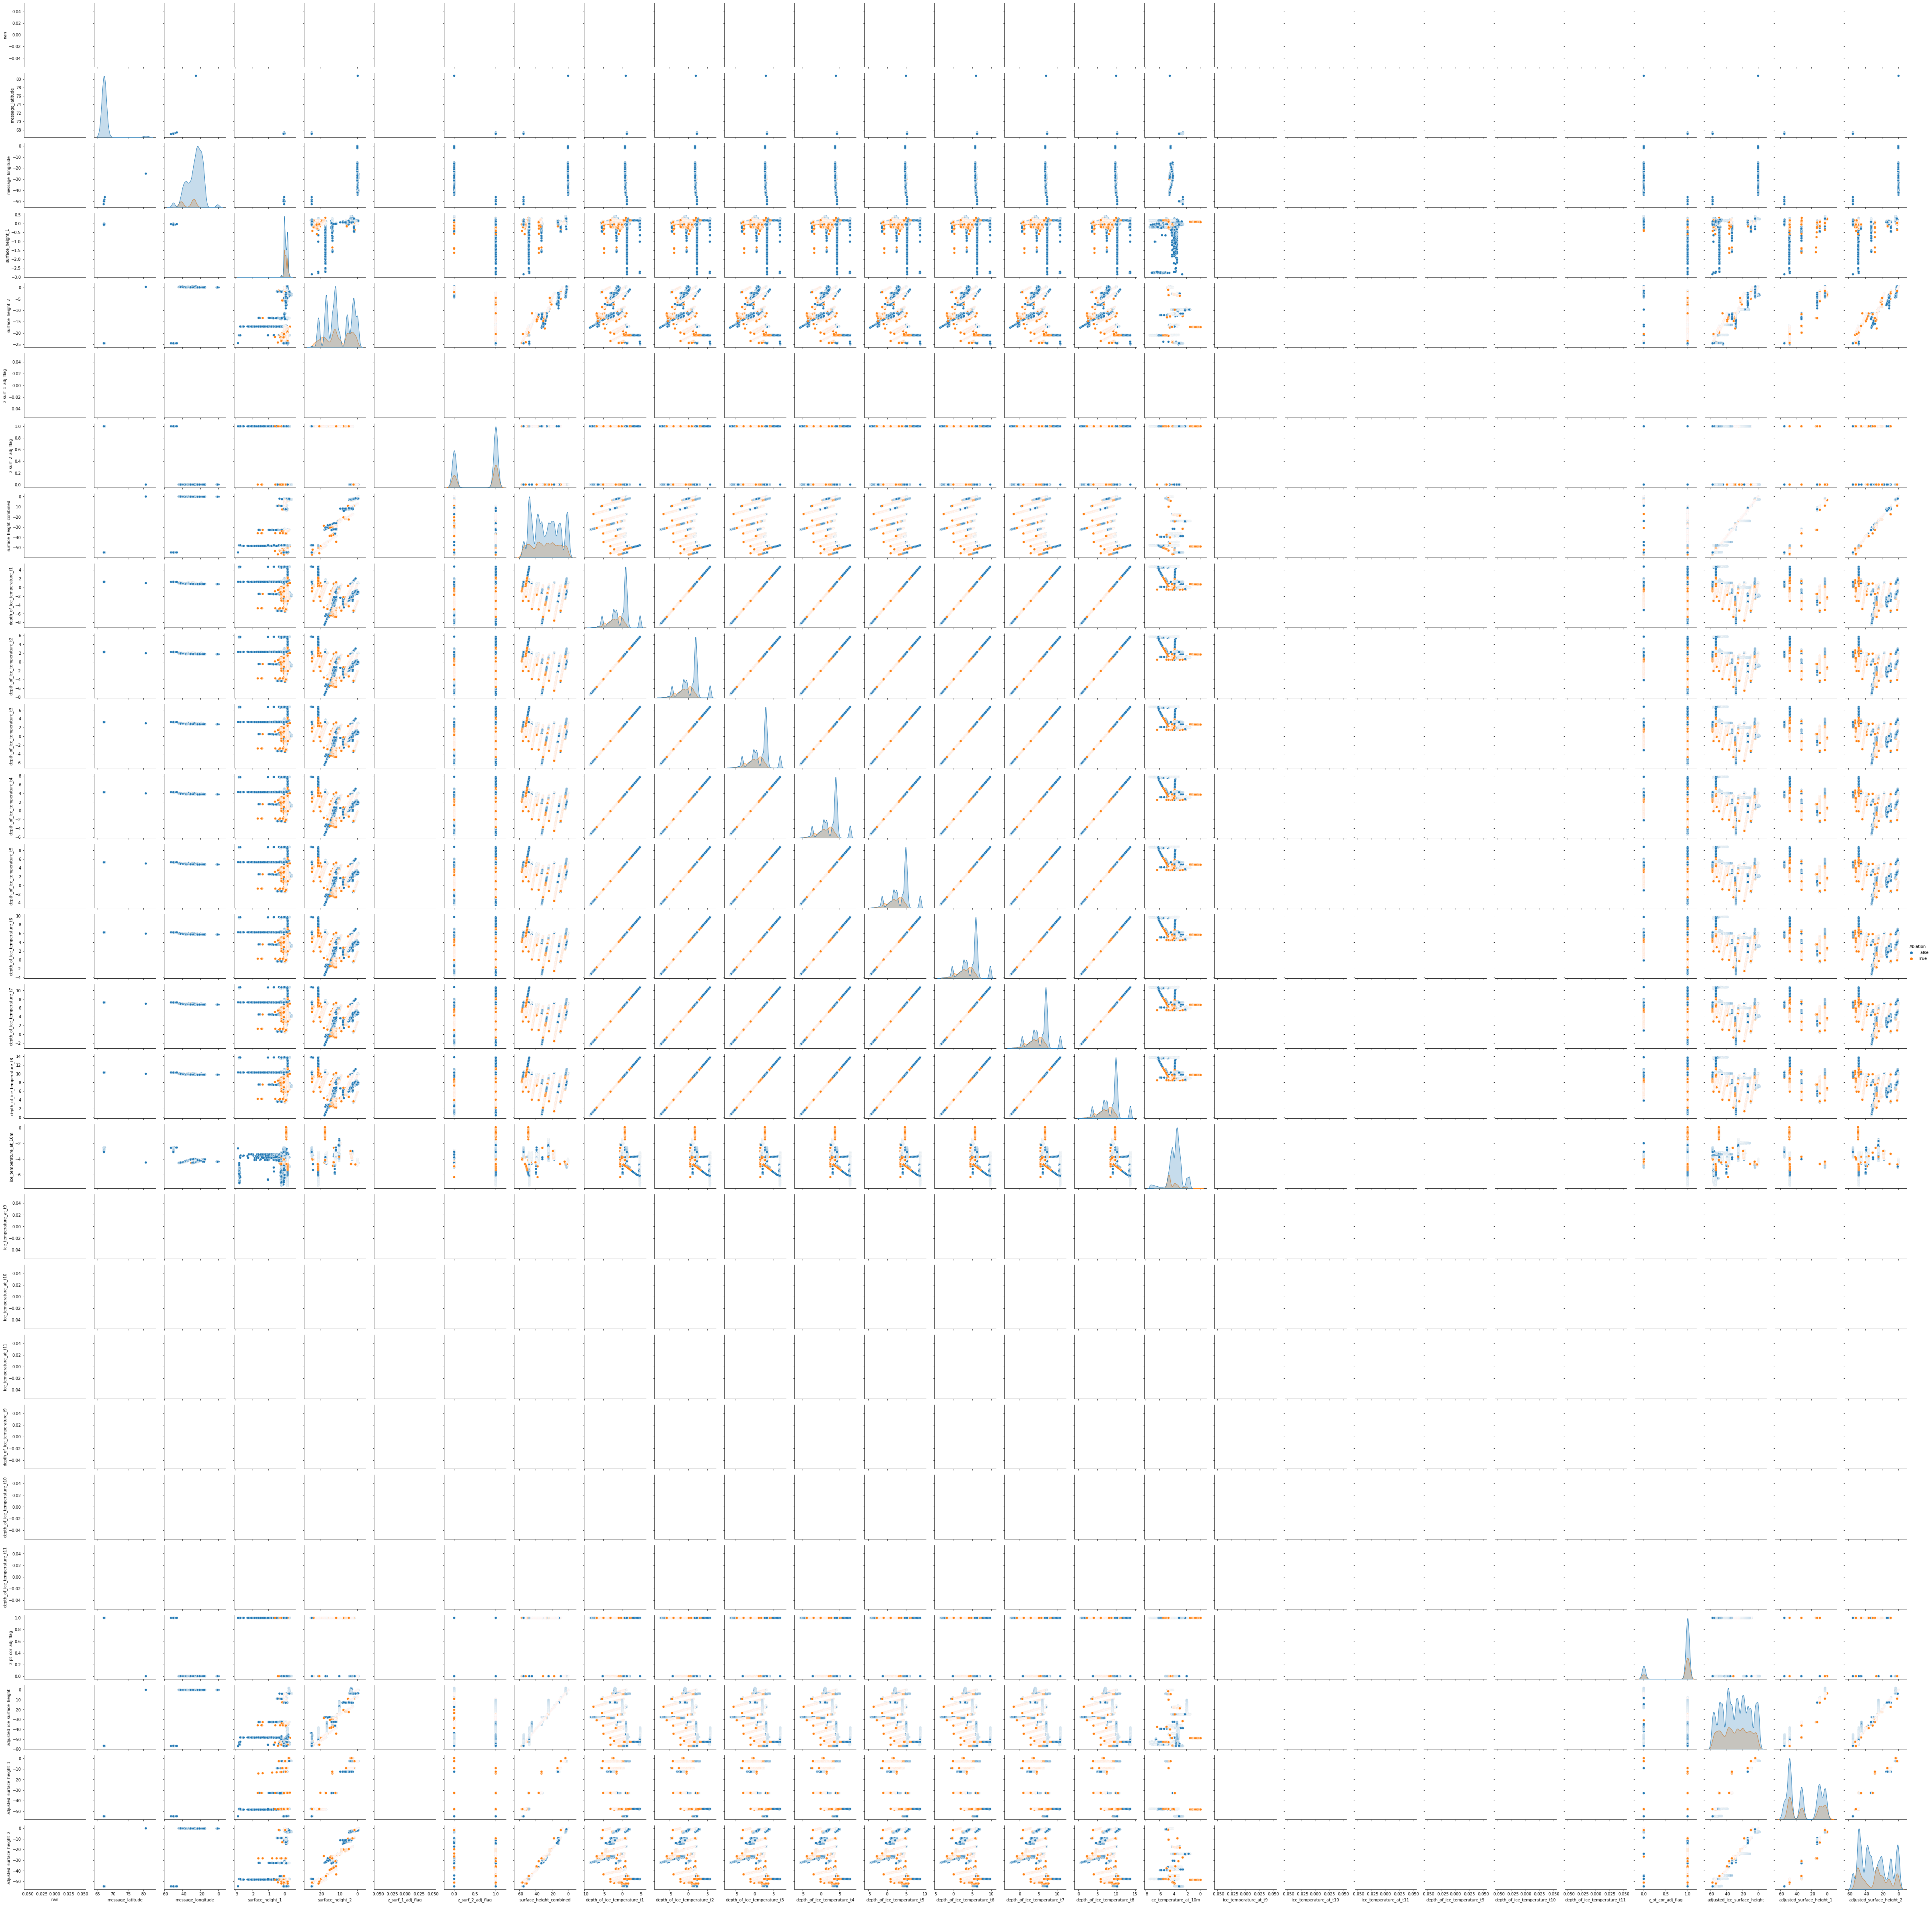

In [51]:
sns.pairplot(data=df[[column for column in df.columns if column not in exclude_list and not isinstance(column, int)]], hue="Ablation")

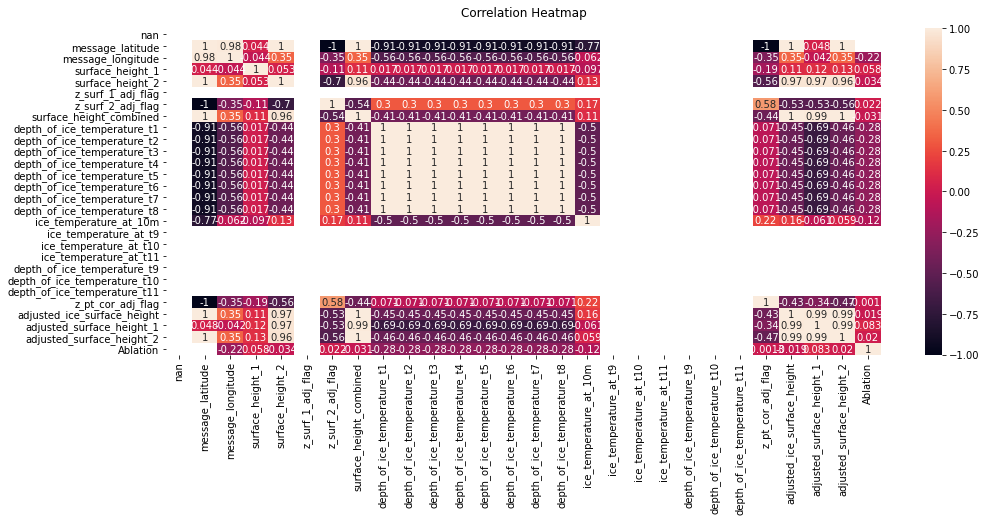

In [52]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df[[column for column in df.columns if column not in exclude_list and not isinstance(column, int)]].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

**PCA**

**Multivariate Regression**